In [2]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

print("Setup Complete")

Setup Complete


# Introduction
We're going to use the dataset on [Kaggle](https://www.kaggle.com/datasets/federalreserve/interest-rates). It contains interest rate data since 1954. The federal funds rate is the interest rate at which banks trade federal funds overnight. The Fed sets a **target** for this, but due to the free market, the **effective** funds rate will be different. Since we're predicting the Fed's decision, we're going to predict the target rate.

According to the dataset description:
> The unemployment rate represents the number of unemployed as a seasonally adjusted percentage of the labor force. The inflation rate reflects the monthly change in the Consumer Price Index of products excluding food and energy.

In [3]:
df = pd.read_csv('index.csv')
df.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


# Data Cleaning
First, let's see how many missing values we have.

In [4]:
df.isnull().sum()

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate    152
Real GDP (Percent Change)       654
Unemployment Rate               152
Inflation Rate                  194
dtype: int64

### Federal Funds Upper/Lower Target
It looks like there are a lot of missing values in `Federal Funds Upper Target` and `Federal Funds Lower Target`. Since this range system was only adopted more recently, we can simply convert them back to single values by calculating their average. Also, there are way too many missing values in `Real GDP (Percent Change)` so we're just going to drop it.

In [5]:
df.loc[df['Federal Funds Target Rate'].isna(), 'Federal Funds Target Rate'] = (df['Federal Funds Upper Target'] + df[
    'Federal Funds Lower Target']) / 2
df = df.drop(['Federal Funds Upper Target', 'Federal Funds Lower Target', 'Real GDP (Percent Change)'], axis=1)
df.head()

,Year,Month,Day,Federal Funds Target Rate,Effective Federal Funds Rate,Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,0.80,5.8,NaN
1,1954,8,1,NaN,1.22,6.0,NaN
2,1954,9,1,NaN,1.06,6.1,NaN
3,1954,10,1,NaN,0.85,5.7,NaN
4,1954,11,1,NaN,0.83,5.3,NaN


### Federal Funds Target Rate, Unemployment Rate, Inflation Rate
Now, let's graph the number of missing `Federal Funds Target Rate`, `Unemployment Rate`, and `Inflation Rate` values by year.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

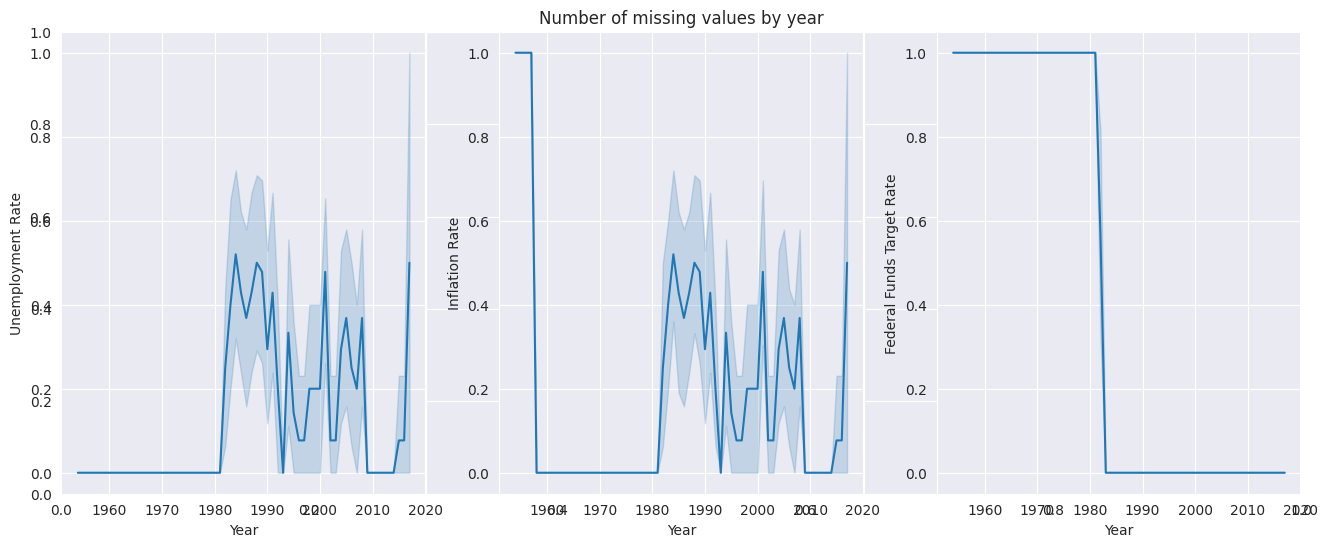

In [6]:
plt.figure(figsize=(16, 6))
plt.title('Number of missing values by year')
# plot 3 graphs separately
plt.subplot(1, 3, 1)
sns.lineplot(x=df['Year'], y=df['Unemployment Rate'].isnull())
plt.subplot(1, 3, 2)
sns.lineplot(x=df['Year'], y=df['Inflation Rate'].isnull())
plt.subplot(1, 3, 3)
sns.lineplot(x=df['Year'], y=df['Federal Funds Target Rate'].isnull())

plt.show()


It seems that the missing values for `Inflation Rate` and `Unemployment Rate` are very erratic, so we can probably just generically impute them later. 
### Effective Federal Funds Rate
However, for `Federal Funds Target Rate`, we can see that the missing values are mostly in the 1950s to the 1970s. Let's see if the years with missing values in `Federal Funds Target Rate` also have missing values in `Effective Federal Funds Rate`.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

<Axes: title={'center': 'Number of missing values by year'}, xlabel='Year', ylabel='Federal Funds Target Rate'>

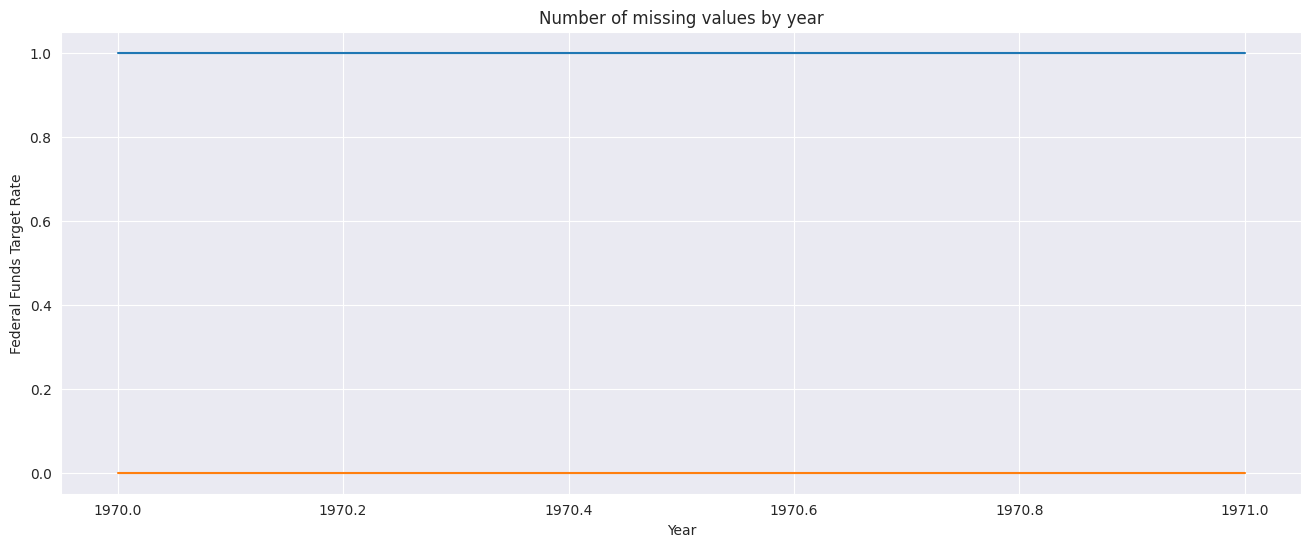

In [7]:
plt.figure(figsize=(16, 6))
plt.title('Number of missing values by year')
sns.lineplot(x=df['Year'], y=df.loc['1950':'1990', 'Federal Funds Target Rate'].isnull())
sns.lineplot(x=df['Year'], y=df.loc['1950':'1990', 'Effective Federal Funds Rate'].isnull())


In [8]:
df.loc[df['Federal Funds Target Rate'].isna(), 'Effective Federal Funds Rate'].notna().sum() / df[
    'Federal Funds Target Rate'].isna().sum()

1.0

It looks like values in `Effective Federal Funds Rate` are always present if the values from `Federal Funds Target Rate` are missing. Therefore, we can just impute the missing values in `Federal Funds Target Rate` with the values in `Effective Federal Funds Rate`, since they are usually very close to each other.

In [9]:
df.loc[df['Federal Funds Target Rate'].isna(), 'Federal Funds Target Rate'] = df.loc[
    df['Federal Funds Target Rate'].isna(), 'Effective Federal Funds Rate']
df.isnull().sum()

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate         0
Effective Federal Funds Rate    152
Unemployment Rate               152
Inflation Rate                  194
dtype: int64

Since we're not going to know what the `Effective Federal Funds Rate` is when predicting in the real world, we can drop that column now.

In [10]:
df = df.drop('Effective Federal Funds Rate', axis=1)
df.isnull().sum()

Year                           0
Month                          0
Day                            0
Federal Funds Target Rate      0
Unemployment Rate            152
Inflation Rate               194
dtype: int64

All that's left is to impute the missing values in `Inflation Rate` and `Unemployment Rate`. We can't derive these values from the existing data, so we'll just use the mean of the previous and next values.

In [11]:
df['Inflation Rate'] = df['Inflation Rate'].interpolate()
df['Unemployment Rate'] = df['Unemployment Rate'].interpolate()
df.isnull().sum()

Year                          0
Month                         0
Day                           0
Federal Funds Target Rate     0
Unemployment Rate             0
Inflation Rate               42
dtype: int64

Let's see where these 42 missing `Inflation Rate` values are.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

<Axes: xlabel='Year', ylabel='Inflation Rate'>

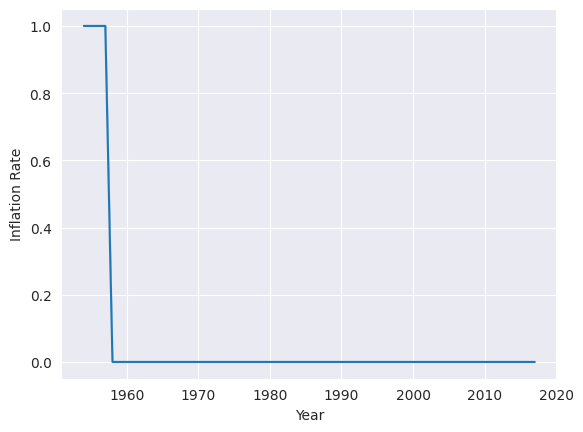

In [12]:
sns.lineplot(x=df['Year'], y=df['Inflation Rate'].isna())

Looks like inflation data wasn't tracked in the 1950s. Since there's only 42 rows and I really want to measure with inflation rate, let's just drop them.

In [13]:
df = df.dropna(subset=['Inflation Rate'])
df.isnull().sum()

Year                         0
Month                        0
Day                          0
Federal Funds Target Rate    0
Unemployment Rate            0
Inflation Rate               0
dtype: int64

## Normalizing Values
For LSTM, we need to normalize the values. We'll use the min-max scaler since it's the most common.

In [14]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
df[['Unemployment Rate', 'Inflation Rate']] = x_scaler.fit_transform(df[['Unemployment Rate', 'Inflation Rate']])
df['Federal Funds Target Rate'] = y_scaler.fit_transform(df[['Federal Funds Target Rate']])
df.head()

,Year,Month,Day,Federal Funds Target Rate,Unemployment Rate,Inflation Rate
42,1958,1,1,0.136759,0.324324,0.200000
43,1958,2,1,0.081423,0.405405,0.200000
44,1958,3,1,0.056653,0.445946,0.169231
45,1958,4,1,0.059816,0.540541,0.138462
46,1958,5,1,0.026614,0.540541,0.138462


# Data Analysis & Feature Engineering
## Correlations
We now only have two columns to predict from: `Unemployment Rate` and `Inflation Rate`. Let's see how they correlate with the `Federal Funds Target Rate`.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

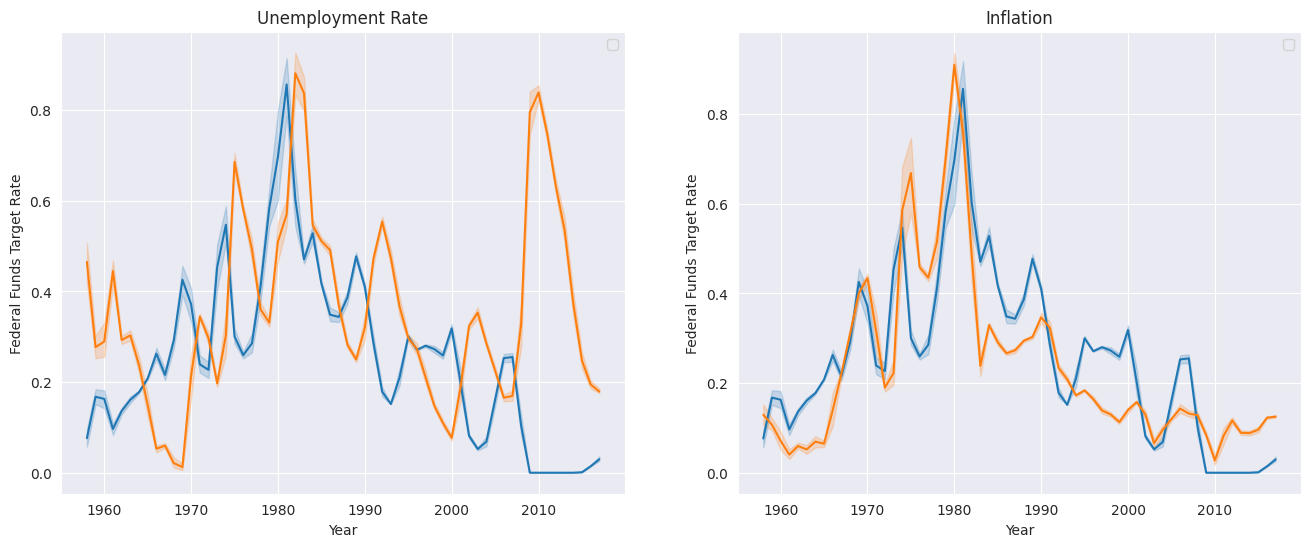

In [15]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(x=df['Year'], y=df['Federal Funds Target Rate'])
sns.lineplot(x=df['Year'], y=df['Unemployment Rate'])
plt.title('Unemployment Rate')
plt.legend()
plt.subplot(122)
sns.lineplot(x=df['Year'], y=df['Federal Funds Target Rate'])
sns.lineplot(x=df['Year'], y=df['Inflation Rate'])
plt.title('Inflation')
plt.legend()
plt.show()


It looks like `Inflation Rate` is more correlated with `Federal Funds Target Rate` than `Unemployment Rate`.
## Data Binning
Let's see how the time values are distributed; particiularly, the day.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

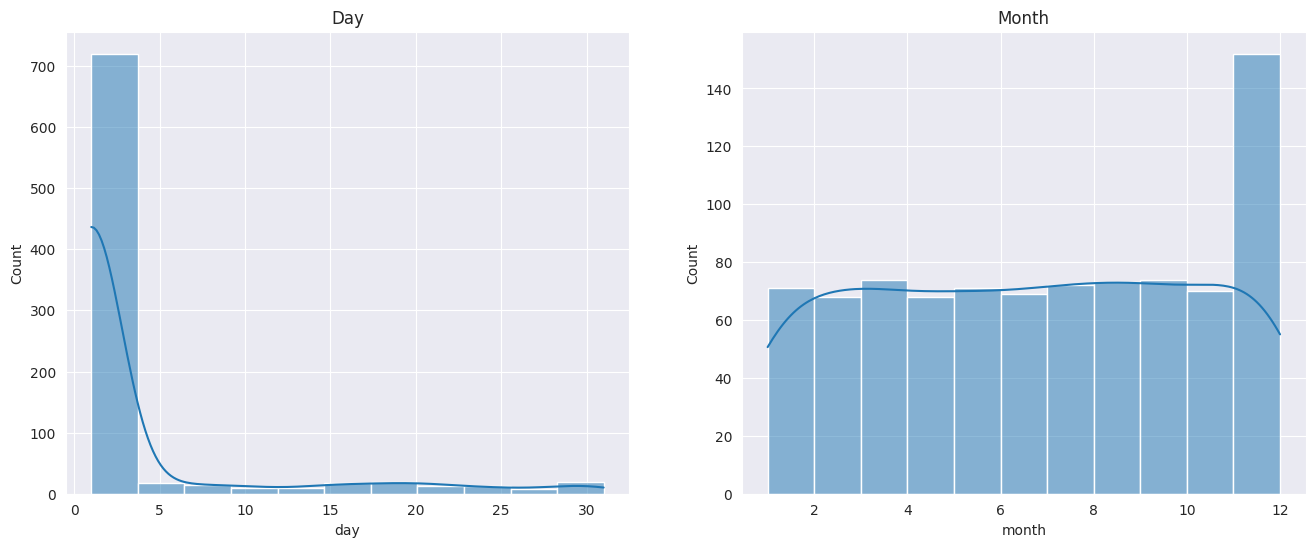

In [16]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.histplot(df['Day'], kde=True)
plt.title('Day')
plt.xlabel('day')
plt.subplot(122)
sns.histplot(df['Month'], kde=True)
plt.xlabel('month')
plt.title('Month')
plt.show()


It looks like the Fed meets pretty consistently every month, but more during the later part of the year. In addition, most of the meetings are on the 1st day of the month. Since we want to make the data as smooth as possible, let's group the data by month/year, taking the average of each bin.

In [17]:
print('Pre-binning shape: ', df.shape)
df = df.groupby(['Year', 'Month'], as_index=False).mean()
df = df.drop('Day', axis=1) # useless now that we've binned
print('Post-binning shape: ', df.shape)
df.head()

Pre-binning shape:  (862, 6)
Post-binning shape:  (711, 5)


,Year,Month,Federal Funds Target Rate,Unemployment Rate,Inflation Rate
0,1958,1,0.136759,0.324324,0.200000
1,1958,2,0.081423,0.405405,0.200000
2,1958,3,0.056653,0.445946,0.169231
3,1958,4,0.059816,0.540541,0.138462
4,1958,5,0.026614,0.540541,0.138462


## Feature Lagging 
Even though LSTM models already have feature lagging "built in", people say that doing it anyway can improve precision further. Let's try it out.

In [18]:
for i in range(1, 13):
    df[f'Unemployment Rate - {i}'] = df['Unemployment Rate'].shift(i)
    df[f'Inflation Rate - {i}'] = df['Inflation Rate'].shift(i)
df = df.dropna()
print(df.shape)
df.head()

(699, 29)


,Year,Month,Federal Funds Target Rate,Unemployment Rate,Inflation Rate,Unemployment Rate - 1,Inflation Rate - 1,Unemployment Rate - 2,Inflation Rate - 2,Unemployment Rate - 3,...,Unemployment Rate - 8,Inflation Rate - 8,Unemployment Rate - 9,Inflation Rate - 9,Unemployment Rate - 10,Inflation Rate - 10,Unemployment Rate - 11,Inflation Rate - 11,Unemployment Rate - 12,Inflation Rate - 12
12,1959,1,0.124111,0.351351,0.084615,0.378378,0.084615,0.378378,0.084615,0.445946,...,0.540541,0.138462,0.540541,0.138462,0.445946,0.169231,0.405405,0.200000,0.324324,0.200000
13,1959,2,0.121476,0.337838,0.084615,0.351351,0.084615,0.378378,0.084615,0.378378,...,0.527027,0.115385,0.540541,0.138462,0.540541,0.138462,0.445946,0.169231,0.405405,0.200000
14,1959,3,0.140975,0.297297,0.084615,0.337838,0.084615,0.351351,0.084615,0.378378,...,0.554054,0.138462,0.527027,0.115385,0.540541,0.138462,0.540541,0.138462,0.445946,0.169231
15,1959,4,0.149407,0.243243,0.084615,0.297297,0.084615,0.337838,0.084615,0.351351,...,0.540541,0.115385,0.554054,0.138462,0.527027,0.115385,0.540541,0.138462,0.540541,0.138462
16,1959,5,0.146245,0.229730,0.107692,0.243243,0.084615,0.297297,0.084615,0.337838,...,0.500000,0.084615,0.540541,0.115385,0.554054,0.138462,0.527027,0.115385,0.540541,0.138462


There's not much else to do, since the data is all numerical and there aren't many columns. We can now move on to model building.

# Model Building
## Train/Validation/Test Split
First, we'll split the data. I'll do a traditional 80/20 split. Since I don't plan on tuning many hyperparameters, we're not going to include a validation oset. We also have to keep the data in order since it's time-series data.

/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

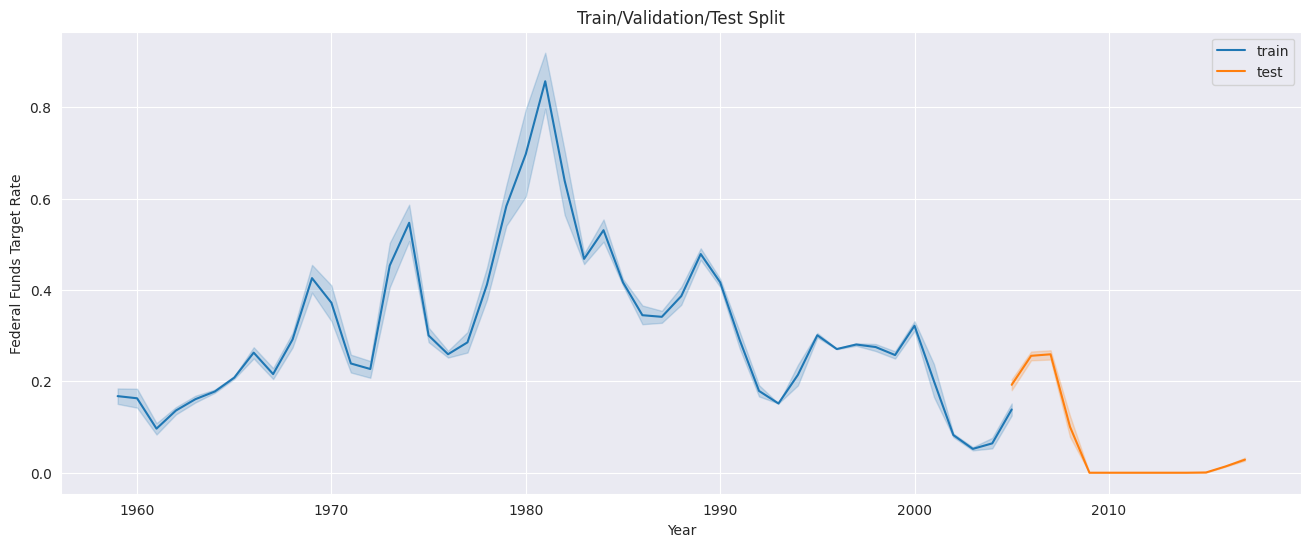

(559, 28) (140, 28)


In [19]:

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, shuffle=False)
plt.figure(figsize=(16, 6))
sns.lineplot(x=train['Year'], y=train['Federal Funds Target Rate'], label='train')
sns.lineplot(x=test['Year'], y=test['Federal Funds Target Rate'], label='test')
plt.title('Train/Validation/Test Split')
plt.legend()
plt.show()
x_train, y_train = train.drop('Federal Funds Target Rate', axis=1), train['Federal Funds Target Rate']
x_test, y_test = test.drop('Federal Funds Target Rate', axis=1), test['Federal Funds Target Rate']
print(x_train.shape, x_test.shape)

## Defining the Model
Now let's define the model. We're going to use recurrent neural networks (RNNs) since they work very well with time-series data. We'll use long short-term memory (LSTM) layers since they're the most popular and are pretty accurate. Lastly, we'll add 20% dropout layers to prevent overfitting.

In [20]:
from keras.src.layers import LSTM, Dense, Dropout
from keras import Sequential, Input
model = Sequential([
    Input(shape=(x_train.shape[1], 1)), # 12 months, 2 features (excluding date)
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()


2023-09-22 19:08:46.574309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 19:08:47.600516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-22 19:08:48.224001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 19:08:48.260000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 19:08:48.260054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 28, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 28, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 28, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 28, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 28, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

## Training the Model
Now let's train the model. After fitting, we'll graph the mean squared error (MSE) to see how well the model did.

Epoch 1/100


2023-09-22 19:08:54.089909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-22 19:08:54.208659: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fea5c02d6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-22 19:08:54.208693: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-09-22 19:08:54.213961: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-22 19:08:54.331797: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 5s 30ms/step - loss: 0.0930
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0399
Epoch 3/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0374
Epoch 4/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0261
Epoch 5/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0371
Epoch 6/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0251
Epoch 7/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0258
Epoch 8/100
5/5 [==============================] - 0s 33ms/step - loss: 0.0248
Epoch 9/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0367
Epoch 10/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0242
Epoch 11/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0239
Epoch 12/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0229
Epoch 13/100
5/5 [==============================] - 0s 20ms/s

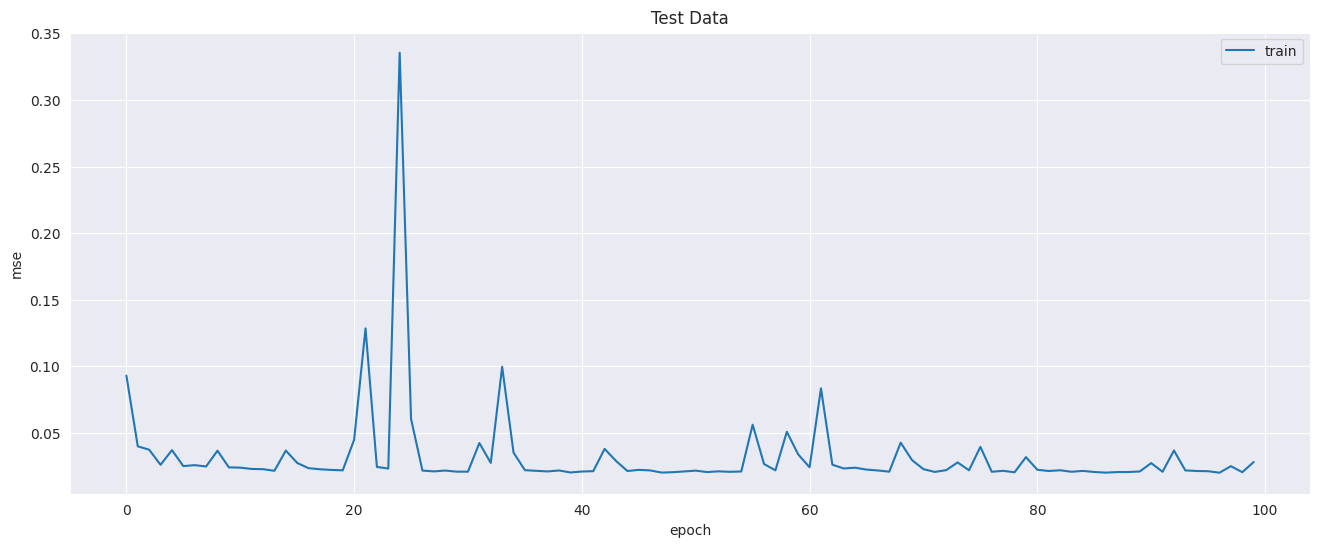

In [21]:
model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=1)

plt.figure(figsize=(16, 6))
plt.title('Test Data')
plt.plot(model.history.history['loss'], label='train')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()
plt.show()

We'll also graph the actual and predicted values to see how close the model was. This is where we'll undo the normalization to get real-world values.

5/5 [==============================] - 0s 6ms/step


/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/newwares/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

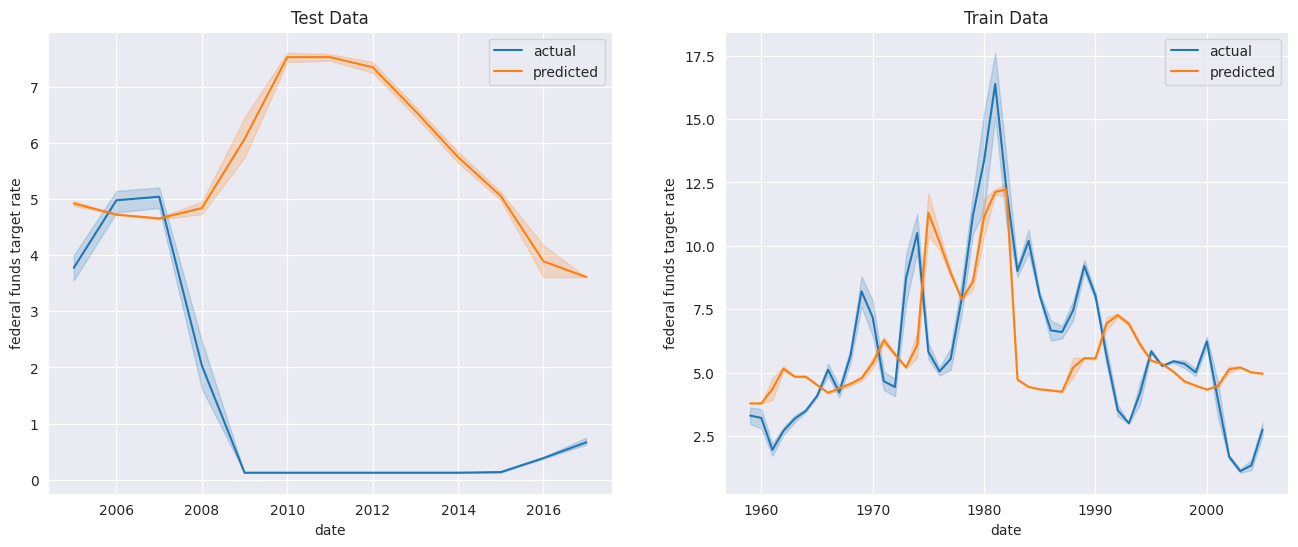

In [22]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)
test_ans = y_scaler.inverse_transform(test_pred).flatten()
train_ans = y_scaler.inverse_transform(train_pred).flatten()

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title('Test Data')
sns.lineplot(x=x_test['Year'], y=y_scaler.inverse_transform(y_test.to_numpy().reshape(-1, 1)).flatten(), label='actual')
sns.lineplot(x=x_test['Year'], y=test_ans, label='predicted')
plt.xlabel('date')
plt.ylabel('federal funds target rate')
plt.legend()
plt.subplot(122)
plt.title('Train Data')
sns.lineplot(x=x_train['Year'], y=y_scaler.inverse_transform(y_train.to_numpy().reshape(-1, 1)).flatten(), label='actual')
sns.lineplot(x=x_train['Year'], y=train_ans, label='predicted')
plt.xlabel('date')
plt.ylabel('federal funds target rate')
plt.legend()
plt.show()